In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [5]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image


In [6]:
import numpy as np
import datetime
import os, sys

In [7]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
class Discriminator(nn.Module):
    """
    Discriminator reusing SimpleClassifier layers, incorporating condition vector
    """
    def __init__(self, num_classes=10):
        super(Discriminator, self).__init__()
        # Convolutional and pooling layers from SimpleClassifier
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Adjusted fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7 + num_classes, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)  # Output for binary classification

    def forward(self, x, c):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten features
        x = x.view(x.size(0), -1)  # [batch_size, 64 * 7 * 7]

        # Ensure condition vector c is of shape [batch_size, num_classes]
        c = c.view(c.size(0), -1).float()

        # Concatenate features and condition vector
        x = torch.cat((x, c), dim=1)  # [batch_size, 64*7*7 + num_classes]

        # Fully connected layers
        x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.2)
        x = torch.sigmoid(self.fc3(x))
        return x


In [10]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, condition_size=10, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size+condition_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )
        
    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.layer(v)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [11]:
def get_sample_image(G, n_noise=100):
    """
        save sample 100 images
    """
    img = np.zeros([280, 280])
    for j in range(10):
        c = torch.zeros([10, 10]).to(DEVICE)
        c[:, j] = 1
        z = torch.randn(10, n_noise).to(DEVICE)
        y_hat = G(z,c).view(10, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

In [12]:
def to_onehot(x, num_classes=10):
    x = x.view(-1).long()
    one_hot = F.one_hot(x, num_classes=num_classes)
    return one_hot

In [13]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

In [14]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [15]:
mnist = datasets.MNIST(root='data/', train=True, transform=transform, download=True)

In [16]:
batch_size = 32
condition_size = 10

In [17]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [18]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [19]:
max_epoch = 20 
step = 0
n_critic = 2
n_noise = 100

In [20]:
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

In [21]:
if not os.path.exists('samples'):
    os.makedirs('samples')


In [22]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        y = labels.view(batch_size, 1)
        y = to_onehot(y).to(DEVICE)
        x_outputs = D(x, y)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z, y), y)
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()
        
        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z, y), y)
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 1000 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        
        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave(f'samples/step_{step}.jpg', img, cmap='gray')
            G.train()
        step += 1

[W NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch: 0/20, Step: 0, D Loss: 1.3889163732528687, G Loss: 0.6923280358314514
Epoch: 0/20, Step: 1000, D Loss: 0.17693352699279785, G Loss: 3.6716926097869873
Epoch: 1/20, Step: 2000, D Loss: 0.043064944446086884, G Loss: 5.37014627456665
Epoch: 1/20, Step: 3000, D Loss: 0.1322532594203949, G Loss: 3.64021635055542
Epoch: 2/20, Step: 4000, D Loss: 0.050268176943063736, G Loss: 5.589104175567627
Epoch: 2/20, Step: 5000, D Loss: 0.10259130597114563, G Loss: 4.9598493576049805
Epoch: 3/20, Step: 6000, D Loss: 0.15637439489364624, G Loss: 4.539552211761475
Epoch: 3/20, Step: 7000, D Loss: 0.06929568946361542, G Loss: 6.215537071228027
Epoch: 4/20, Step: 8000, D Loss: 0.1411021500825882, G Loss: 3.935129165649414
Epoch: 4/20, Step: 9000, D Loss: 0.011389763094484806, G Loss: 6.192360877990723
Epoch: 5/20, Step: 10000, D Loss: 0.13628284633159637, G Loss: 5.947079658508301
Epoch: 5/20, Step: 11000, D Loss: 0.049089670181274414, G Loss: 4.929867267608643
Epoch: 6/20, Step: 12000, D Loss: 0.017

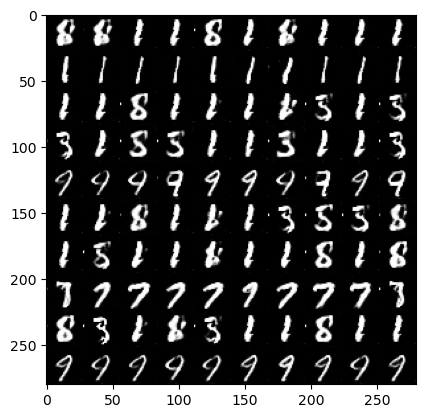

In [35]:
import matplotlib.pyplot as plt
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='grey')
plt.show()

In [25]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name) 

# Saving params.
save_checkpoint({'epoch': epoch + 1, 'state_dict':D.state_dict(), 'optimizer' : D_opt.state_dict()}, 'D_c.pth.tar')
save_checkpoint({'epoch': epoch + 1, 'state_dict':G.state_dict(), 'optimizer' : G_opt.state_dict()}, 'G_c.pth.tar')